# Feature Engineering

## 1. Imports

In [1]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

import lightgbm as lgb

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [2]:
class path:
    train = '../../input/train.csv'
    dataset = '../dataset'

## 2. Fix Seed

In [3]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

## 3. Load Data

In [4]:
df = pd.read_csv(path.train, parse_dates=['order_date'])
df.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


## 4. Feature Engineering

2009년 12월부터 2011년 11월까지 300이 넘는지/안 넘는지만 표시한다.

### 4.1. 2009년 12월부터 2011년 11월까지의 월별 total 합
- 2011년 11의 경우 평가를 위해 300이 넘는지 여부인 `label` 피처를 새로 생성한다.

In [5]:
# year_month 피처 생성
df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
df.reset_index(drop=True, inplace=True)
df.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,2009-12


In [7]:
# 새로운 데이터프레임 생성
customers = df.customer_id.sort_values().unique()
customer_df = pd.DataFrame({'customer_id':customers})
for year_month in df.year_month.unique():
    customer_df[f'total_{year_month}'] = 0
customer_df.head()

,customer_id,total_2009-12,total_2010-01,total_2010-02,total_2010-03,total_2010-04,total_2010-05,total_2010-06,total_2010-07,total_2010-08,total_2010-09,total_2010-10,total_2010-11,total_2010-12,total_2011-01,total_2011-02,total_2011-03,total_2011-04,total_2011-05,total_2011-06,total_2011-07,total_2011-08,total_2011-09,total_2011-10,total_2011-11
0,12346,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# customer_id와 year_month별 total 합
grouped = df.groupby(['customer_id', 'year_month'], as_index=False)[['total']].sum()

# 각 customer_id에 각 year별 total 합 생성
for cust in customers:
    cust_df = grouped[grouped.customer_id==cust]
    for year_month in cust_df.year_month.unique():
        customer_df.loc[(customer_df.customer_id==cust), f'total_{year_month}'] = cust_df[cust_df.year_month==year_month]['total'].to_numpy()

# 비어있는 값 0으로 채우기
customer_df.fillna(0)

# 2011년 11월 total값만 라벨로 변환
thres = 300
customer_df['total_2010-11'] = customer_df['total_2010-11'].apply(lambda x: 1 if x >= thres else 0)
customer_df.head()


,customer_id,total_2009-12,total_2010-01,total_2010-02,total_2010-03,total_2010-04,total_2010-05,total_2010-06,total_2010-07,total_2010-08,total_2010-09,total_2010-10,total_2010-11,total_2010-12,total_2011-01,total_2011-02,total_2011-03,total_2011-04,total_2011-05,total_2011-06,total_2011-07,total_2011-08,total_2011-09,total_2011-10,total_2011-11
0,12346,187.2750,-22.275,0.0,44.6325,0.000,0.0,-285.9285,0.0,0.0,0.000,-9.0750,0,0.0000,0.0000,0.00,0.0,0.0000,0.0,0.000,0.0,0.0000,0.0,0.000,0.0000
1,12347,0.0000,0.000,0.0,0.0000,0.000,0.0,0.0000,0.0,0.0,0.000,1009.0245,0,1174.4535,784.3935,0.00,0.0,1049.8125,0.0,631.158,0.0,965.1015,0.0,2135.628,0.0000
2,12348,0.0000,0.000,0.0,0.0000,0.000,0.0,0.0000,0.0,0.0,366.564,0.0000,0,1473.1200,375.2760,0.00,0.0,605.5500,0.0,0.000,0.0,0.0000,511.5,0.000,0.0000
3,12349,-39.8475,0.000,0.0,0.0000,1763.058,330.0,0.0000,0.0,0.0,0.000,2314.3230,0,0.0000,0.0000,0.00,0.0,0.0000,0.0,0.000,0.0,0.0000,0.0,0.000,2899.9575
4,12350,0.0000,0.000,0.0,0.0000,0.000,0.0,0.0000,0.0,0.0,0.000,0.0000,0,0.0000,0.0000,551.76,0.0,0.0000,0.0,0.000,0.0,0.0000,0.0,0.000,0.0000


In [8]:
def preprocessing(df, total_thres=300, is_hard=True):
    df = df.copy()

    # year_month 피처 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # 새로운 데이터프레임 생성
    customers = df.customer_id.sort_values().unique()
    result = pd.DataFrame({'customer_id':customers})
    for year_month in df.year_month.unique():
        result[f'total_{year_month}'] = 0
    
    # customer_id와 year_month별 total 합
    grouped = df.groupby(['customer_id', 'year_month'], as_index=False)[['total']].sum()

    # 각 customer_id에 각 year별 total 합 생성
    for cust in customers:
        cust_df = grouped[grouped.customer_id==cust]
        for year_month in cust_df.year_month.unique():
            result.loc[(result.customer_id==cust), f'total_{year_month}'] = cust_df[cust_df.year_month==year_month]['total'].to_numpy()

    result.fillna(0)

    if is_hard:
        for year_month in grouped.year_month.unique():
            result[f'total_{year_month}'] = result[f'total_{year_month}'].apply(lambda x: 1 if x >= total_thres else 0)
    
    return result

In [9]:
temp = df.copy()
df_prep01_hard = preprocessing(temp)
df_prep01_hard.to_csv(f'{path.dataset}/prep_hard.csv', mode='w')
df_prep01_hard.head()

,customer_id,total_2009-12,total_2010-01,total_2010-02,total_2010-03,total_2010-04,total_2010-05,total_2010-06,total_2010-07,total_2010-08,total_2010-09,total_2010-10,total_2010-11,total_2010-12,total_2011-01,total_2011-02,total_2011-03,total_2011-04,total_2011-05,total_2011-06,total_2011-07,total_2011-08,total_2011-09,total_2011-10,total_2011-11
0,12346,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12347,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0
2,12348,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0
3,12349,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


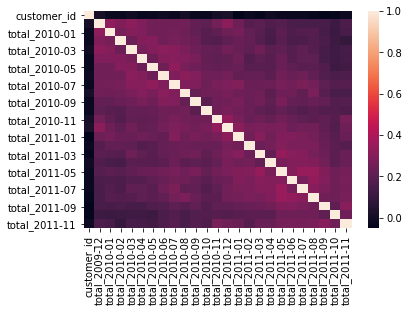

In [10]:
df_prep01_soft = preprocessing(temp, is_hard=False)
df_prep01_soft.to_csv(f'{path.dataset}/prep_soft.csv', mode='w')
df_prep01_soft.head()

,customer_id,total_2009-12,total_2010-01,total_2010-02,total_2010-03,total_2010-04,total_2010-05,total_2010-06,total_2010-07,total_2010-08,total_2010-09,total_2010-10,total_2010-11,total_2010-12,total_2011-01,total_2011-02,total_2011-03,total_2011-04,total_2011-05,total_2011-06,total_2011-07,total_2011-08,total_2011-09,total_2011-10,total_2011-11
0,12346,187.2750,-22.275,0.0,44.6325,0.000,0.0,-285.9285,0.0,0.0,0.000,-9.0750,0.0,0.0000,0.0000,0.00,0.0,0.0000,0.0,0.000,0.0,0.0000,0.0,0.000,0.0000
1,12347,0.0000,0.000,0.0,0.0000,0.000,0.0,0.0000,0.0,0.0,0.000,1009.0245,0.0,1174.4535,784.3935,0.00,0.0,1049.8125,0.0,631.158,0.0,965.1015,0.0,2135.628,0.0000
2,12348,0.0000,0.000,0.0,0.0000,0.000,0.0,0.0000,0.0,0.0,366.564,0.0000,0.0,1473.1200,375.2760,0.00,0.0,605.5500,0.0,0.000,0.0,0.0000,511.5,0.000,0.0000
3,12349,-39.8475,0.000,0.0,0.0000,1763.058,330.0,0.0000,0.0,0.0,0.000,2314.3230,0.0,0.0000,0.0000,0.00,0.0,0.0000,0.0,0.000,0.0,0.0000,0.0,0.000,2899.9575
4,12350,0.0000,0.000,0.0,0.0000,0.000,0.0,0.0000,0.0,0.0,0.000,0.0000,0.0,0.0000,0.0000,551.76,0.0,0.0000,0.0,0.000,0.0,0.0000,0.0,0.000,0.0000


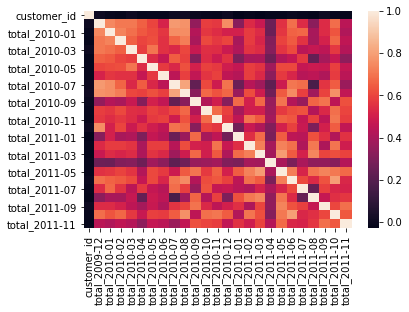

In [11]:
corr = df_prep01_soft.corr()
sns.heatmap(corr)

## 5. Modeling

In [12]:
model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.8, # 피처 샘플링 비율
    'bagging_fraction': 0.8, # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 10000, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': SEED,
    'verbose': -1,
    'n_jobs': -1,    
}

In [2]:
def make_lgb_oof_prediction(train, y, test, features, categorical_features='auto', model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr)
        dvalid = lgb.Dataset(x_val, label=y_val)
        
        # LightGBM 모델 훈련
        clf = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            categorical_feature=categorical_features,
            verbose_eval=200
        )

        # Validation 데이터 예측
        val_preds = clf.predict(x_val)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(x_test) / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi